# Analytical Solution of the Dynamic Control Equations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy
import numpy as np

In [3]:
sympy.init_printing()

In [4]:
%matplotlib notebook

In [5]:
import matplotlib.pylab as plt

## Analytic Solution

In [6]:
def analytical_solutions():
    α, β = sympy.symbols(r'\alpha_1, \beta_a', cls=sympy.Function)
    κ = sympy.symbols(r'\kappa', positive=True)
    t = sympy.symbols(r't', real=True)
    c1 = κ / sympy.sqrt(2)
    c2 = κ * sympy.sqrt(2)

    DE1 = sympy.Eq(α(t).diff(t), c1 * β(t))
    DE2 = sympy.Eq(β(t).diff(t), -κ * β(t) - c2 * α(t))

    # At this point, `sympy` is still buggy for solving systems of linear
    # differential equations, so we do it "by hand"

    coeff_matrix = sympy.Matrix([[0, c1], [-c2, -κ]])

    (lambda1, __, v1), (lambda2, __, v2) = coeff_matrix.eigenvects()

    # The general solution is:

    C1, C2 = sympy.symbols('C1, C2') # integration constants

    sol = C1 * v1[0] * sympy.exp(lambda1 * t) \
          + C2 * v2[0] * sympy.exp(lambda2 * t)
    sol_alpha, sol_beta = sol

    # Check the solution:
    subs = {α(t): sol_alpha, β(t): sol_beta}
    assert (sympy.diff(sol_alpha, t) - DE1.rhs.subs(subs)).simplify() == 0
    assert (sympy.diff(sol_beta, t) - DE2.rhs.subs(subs)).simplify() == 0

    # Now determine the integration constants:

    C1_sol, = sympy.solve(
        sympy.Eq(sol_alpha.subs({t: 0}),
                 sympy.Rational(1,2)),
        C1)

    C2_sol, = sympy.solve(
        sympy.Eq(sol_beta.subs({t: 0}),
                 -1/sympy.sqrt(2))
        .subs({C1: C1_sol}).simplify(),
        C2)
    C2_sol = C2_sol.expand(complex=True)

    C1_sol = C1_sol.subs({C2: C2_sol}).expand(complex=True)

    # We finish up by plugging this into the general solution:

    sol_alpha1 = sol_alpha.subs({C1: C1_sol, C2: C2_sol}).expand(complex=True)
    sol_beta = sol_beta.subs({C1: C1_sol, C2: C2_sol}).expand(complex=True)

    # We now use the normalization condition to determine $\alpha_2(t)$, and
    # then $g_1(-t)$

    sol_alpha2 = sympy.sqrt(1 - sympy.Abs(sol_alpha1)**2
                            - sympy.Abs(sol_beta)**2).simplify()

    sol_g1 = (- (c2 * sol_beta + κ * sol_alpha1) / sol_alpha2).simplify()

    return sol_alpha1, sol_alpha2, sol_beta, sol_g1


In [7]:
sol_alpha1, sol_alpha2, sol_beta, sol_g1 = analytical_solutions()

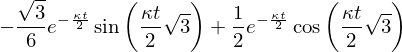

In [8]:
sol_alpha1

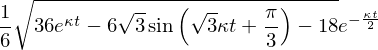

In [9]:
sol_alpha2

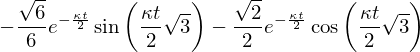

In [10]:
sol_beta

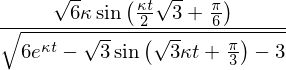

In [11]:
sol_g1

## Plot

Let's plot the solution for comparison with the paper

In [12]:
def lambdify_solution(sol, unit=1):
    κ = sympy.symbols(r'\kappa', positive=True)
    t = sympy.symbols(r't', real=True)
    if unit == 'kappa':
        unit = κ
    return sympy.lambdify(t, (sol.subs({t: -t/κ})/unit).simplify(), "numpy")

In [13]:
alpha1_plot = lambdify_solution(sol_alpha1)
alpha2_plot = lambdify_solution(sol_alpha2)
beta_plot = lambdify_solution(sol_beta)
g1_plot = lambdify_solution(sol_g1, unit='kappa')

<IPython.core.display.Javascript object>


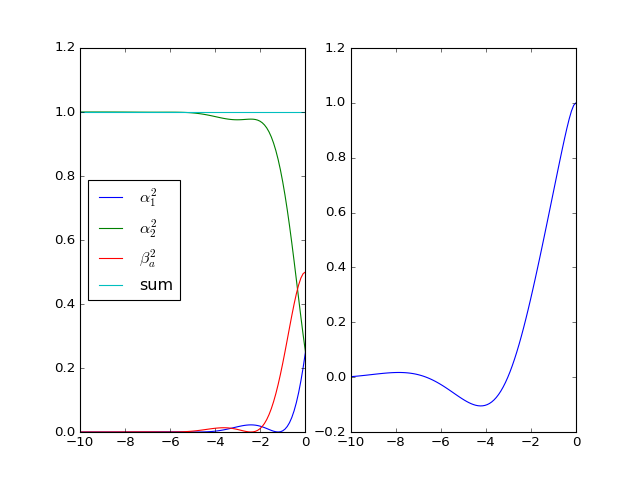

In [14]:
def show_g1():
    fig = plt.figure()
    ax = fig.add_subplot(121)
    tgrid = np.linspace(-10,0,100)
    ax.plot(tgrid, alpha1_plot(tgrid)**2, label=r'$\alpha_1^2$')
    ax.plot(tgrid, alpha2_plot(tgrid)**2, label=r'$\alpha_2^2$')
    ax.plot(tgrid, beta_plot(tgrid)**2, label=r'$\beta_a^2$')
    ax.plot(tgrid, alpha1_plot(tgrid)**2 + alpha2_plot(tgrid)**2 + beta_plot(tgrid)**2,
            label=r'sum')
    ax.legend(loc='center left')
    ax = fig.add_subplot(122)
    ax.plot(tgrid, g1_plot(tgrid))
show_g1()

<IPython.core.display.Javascript object>


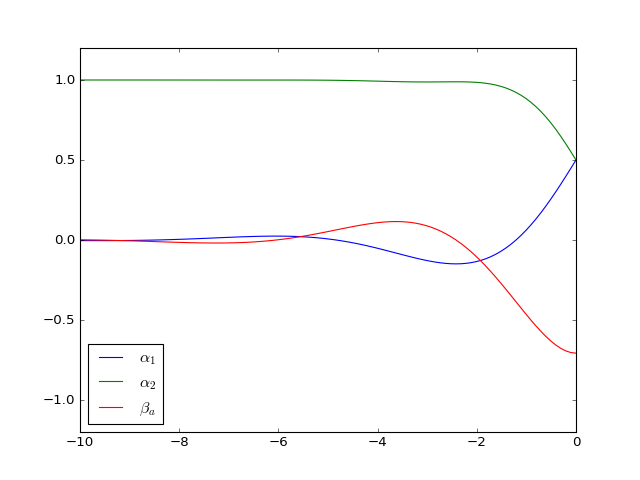

In [15]:
def show_alpha():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    tgrid = np.linspace(-10,0,100)
    ax.plot(tgrid, alpha1_plot(tgrid), label=r'$\alpha_1$')
    ax.plot(tgrid, alpha2_plot(tgrid), label=r'$\alpha_2$')
    ax.plot(tgrid, beta_plot(tgrid), label=r'$\beta_a$')
    ax.set_ylim(-1.2, 1.2)
    ax.legend(loc='best')
show_alpha()

In [16]:
def make_omega(Delta, g, kappa):
    """Construct functions Omega1(tgrid), Omega2(tgrid) that take tgrid
    in microseconds and return the pulse amplitude in MHz"""
    t = sympy.symbols(r't', real=True)
    κ = sympy.symbols(r'\kappa', positive=True)
    two_pi = 2 * np.pi
    g1_vect = sympy.lambdify(t, (sol_g1.subs({κ: kappa*two_pi}) / two_pi),
                             "numpy")
    # units microsec and MHz are taken into account by factors 2 pi above
    const = 2 * Delta / g
    def Omega1(t):
        return const * np.where(t < 0, g1_vect(np.abs(t)),(0*t + kappa))
    def Omega2(t):
        return const * np.where(t > 0, g1_vect(np.abs(t)), (0*t + kappa))
    return Omega1, Omega2

<IPython.core.display.Javascript object>


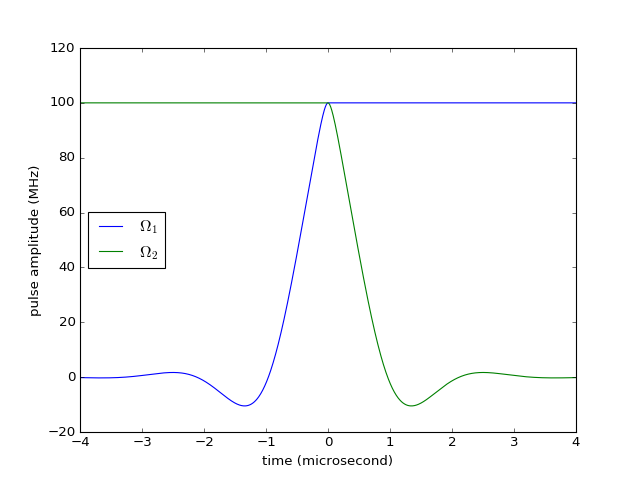

In [17]:
def show_omega():
    Omega1, Omega2 = make_omega(kappa=0.5, g=50, Delta=5000) # MHz
    fig = plt.figure()
    ax = fig.add_subplot(111)
    tgrid = np.linspace(-4,4,1000) # microsecond
    ax.plot(tgrid, Omega1(tgrid), label=r'$\Omega_1$')
    ax.plot(tgrid, Omega2(tgrid), label=r'$\Omega_2$')
    ax.legend(loc='center left')
    ax.set_ylim(-20, 120)
    ax.set_xlabel("time (microsecond)")
    ax.set_ylabel("pulse amplitude (MHz)")
show_omega()

## Output of Numerical Pulses

In [18]:
import QDYN

In [19]:
Delta = 5000  # MHz
g     =   50  # MHz
kappa =  0.5  # MHz
t0    = -4    # microsec
T     =  4    # microsec
nt    = 2001

In [20]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec
ampl_1, ampl_2 = make_omega(Delta, g, kappa)
omega1 = QDYN.pulse.Pulse(tgrid, ampl_1(tgrid), time_unit='microsec',
                          ampl_unit='MHz', freq_unit='MHz')
omega2 = QDYN.pulse.Pulse(tgrid, ampl_2(tgrid), time_unit='microsec',
                          ampl_unit='MHz', freq_unit='MHz')
omega1.write("omega1_analytical.dat")
omega2.write("omega2_analytical.dat")

## Variations

### Shorter duration (compressed)

In [21]:
Delta = 5000  # MHz
g     =   50  # MHz
kappa =  0.5  # MHz
t0    = -0.5    # microsec
T     =  0.5    # microsec
nt    = 2001

In [22]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec
ampl_1, ampl_2 = make_omega(Delta, g, kappa)
omega1 = QDYN.pulse.Pulse(tgrid, ampl_1(4*tgrid), time_unit='microsec',
                          ampl_unit='MHz', freq_unit='MHz')
omega2 = QDYN.pulse.Pulse(tgrid, ampl_2(4*tgrid), time_unit='microsec',
                          ampl_unit='MHz', freq_unit='MHz')
# not compression factor 4 above!
omega1.write("omega1_short.dat")
omega2.write("omega2_short.dat")

### Symmetrized

In [37]:
Delta = 5000  # MHz
g     =   50  # MHz
kappa =  0.5  # MHz
t0    = -4    # microsec
T     =  4    # microsec
nt    = 2001

In [39]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec
ampl_1, ampl_2 = make_omega(Delta, g, kappa)
amplitude_1 = np.minimum(ampl_1(tgrid), ampl_2(tgrid))
amplitude_2 = np.minimum(ampl_1(tgrid), ampl_2(tgrid))
omega1 = QDYN.pulse.Pulse(tgrid, amplitude_1, time_unit='microsec',
                          ampl_unit='MHz', freq_unit='MHz')
omega2 = QDYN.pulse.Pulse(tgrid, amplitude_2, time_unit='microsec',
                          ampl_unit='MHz', freq_unit='MHz')
omega1.write("omega1_symmetrized.dat")
omega2.write("omega2_symetrized.dat")